<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Classification on Auto Insurance Dataset</div>

<br><br><br>



The objective of this notebook is the analysis of an Auto Insurance dataset. We will explore the dataset and then build a supervised classifier

# 1. <a id="sec1"></a>Data Exploration and Preprocessing
We will first look at the data and make it usable to build a prediction model <br>
## <a id="sec3-1"></a> 1.1 Data Description

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

FOLDER_PATH = '/Users/salimbaddou/DESCARTES/auto-insurance-fall-2017/'

df = pd.read_csv(FOLDER_PATH + '/train_auto.csv')

In [2]:
df.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [3]:
print("Shape:",df.shape)
print(df.dtypes)

Shape: (8161, 26)
INDEX            int64
TARGET_FLAG      int64
TARGET_AMT     float64
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME          object
PARENT1         object
HOME_VAL        object
MSTATUS         object
SEX             object
EDUCATION       object
JOB             object
TRAVTIME         int64
CAR_USE         object
BLUEBOOK        object
TIF              int64
CAR_TYPE        object
RED_CAR         object
OLDCLAIM        object
CLM_FREQ         int64
REVOKED         object
MVR_PTS          int64
CAR_AGE        float64
URBANICITY      object
dtype: object


There are 8126 entries in the dataset and 26 different features. Features consist both of categorical and numerical variables

Percentage of TARGET_FLAG tagged as 0: 74 %
Percentage of TARGET_FLAG tagged as 1: 26 %


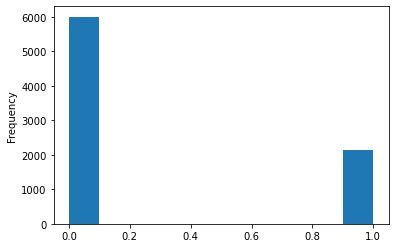

In [4]:
df['TARGET_FLAG'].plot(kind='hist')
false = df['TARGET_FLAG'].value_counts()[0]
true = df['TARGET_FLAG'].value_counts()[1]
p_false = false/(true+false)
p_true = true/(true+false)
print("Percentage of TARGET_FLAG tagged as 0: {} %".format(round(p_false*100)))
print("Percentage of TARGET_FLAG tagged as 1: {} %".format(round(p_true*100)))

The Dataset is a bit imbalanced. This will affect the type of metric we will use to qualify the quality of our predictor

## 1.2 Preprocessing

### 1.2.1 Encoding

We need to transform number encoded as string to numerical data:

In [5]:
string_columns = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']

for e in string_columns:
    df.loc[df[e].notna(),e]  = df[df[e].notna()][e].apply(lambda x: x.split('$')[-1].replace(',',''))
    df[e] = pd.to_numeric(df[e])


We  also need to transform categorical data encoded as string to numerical data:

In [6]:
from sklearn.preprocessing import LabelEncoder

mapping = {'<High School' : 1 ,'z_High School':2 , 'Bachelors':3,'Masters':4 ,'PhD':5}
df.EDUCATION = df.EDUCATION.map(mapping)  #for education we might preserve order relationship for shortest to longest studies


categorical_features = ['PARENT1','MSTATUS','SEX','JOB','CAR_USE','CAR_TYPE','RED_CAR','REVOKED','URBANICITY']  

for feature in categorical_features:
    le = LabelEncoder()
    df.loc[df[feature].notna(),feature] = le.fit_transform(df[df[feature].notna()][feature])

### 1.2.2 Anomalies

In [7]:
df.loc[df.CAR_AGE < 0,'CAR_AGE'] = 0  

### 1.2.3 Missing values

In [8]:
print("Dataset length after deleting all rows with missing values: ",df.dropna().shape[0])

Dataset length after deleting all rows with missing values:  6045


This is an important information loss. Instead of deleting rows we are going to input missing values

In [9]:
print("Missing values per features: ")
df.isna().sum()

Missing values per features: 


INDEX            0
TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64

Only 6 values are missing for age, we procede with mean imputation:

In [10]:
df.AGE.fillna(df.AGE.mean(),inplace=True)

<AxesSubplot:xlabel='HOME_VAL', ylabel='INCOME'>

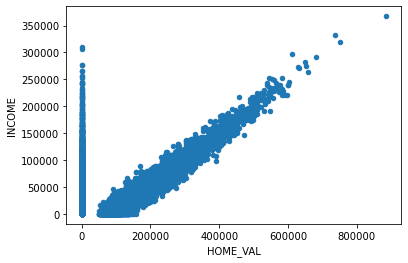

In [11]:
df.plot.scatter(x='HOME_VAL',y='INCOME')

For non zero value of HOME_VAL we can see a clear linear relationship with the feature INCOME. We will procede to a linear regression to input INCOME value with a corresponding non zero HOME_VAL value

In [12]:
from sklearn.linear_model import LinearRegression
x = df[df.INCOME.notna() & df.HOME_VAL.notna() & (df.HOME_VAL != 0)].HOME_VAL
y = df[df.INCOME.notna() & df.HOME_VAL.notna() &(df.HOME_VAL != 0)].INCOME
lr = LinearRegression()
lr.fit(x.values.reshape(-1,1),y.values.reshape(-1,1))
print(lr.coef_)
print(lr.intercept_)

df.loc[df.INCOME.isna() & df.HOME_VAL.notna(),'INCOME'] = df[df.INCOME.isna() & df.HOME_VAL.notna()].HOME_VAL.apply(lambda x : x*lr.coef_[0][0])

[[0.45802645]]
[-35872.34465377]


<AxesSubplot:xlabel='EDUCATION', ylabel='INCOME'>

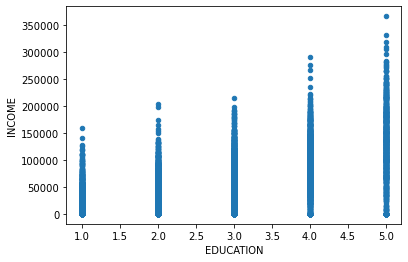

In [13]:
df.plot.scatter(x = 'EDUCATION',y='INCOME')

The distribution of INCOME across the EDUCATION variable can help us to input missing values for INCOME with the mean value for each level of study. The same goes for HOME_VAL and CAR_AGE.

In [14]:
df.loc[df.INCOME.isna(),'INCOME'] = df.EDUCATION.apply(lambda x : df[df['EDUCATION'] == x]['INCOME'].mean())
df.loc[df.HOME_VAL.isna(),'HOME_VAL'] = df.EDUCATION.apply(lambda x : df[df['EDUCATION'] == x]['HOME_VAL'].mean())
df.loc[df.CAR_AGE.isna(),'CAR_AGE'] = df.EDUCATION.apply(lambda x : round(df[df['EDUCATION'] == x]['CAR_AGE'].mean()))

For missing JOB value we input with the most represented job among the corresponding level of study

In [15]:
df.loc[df.JOB.isna(),'JOB'] = df[df.JOB.isna()].EDUCATION.apply(lambda x : df[df['EDUCATION'] == x]['JOB'].mode()[0])

In [16]:
df.YOJ.fillna(df.YOJ.mode()[0],inplace=True)

We don't have any missing values left:

In [17]:
df.isna().sum()

INDEX          0
TARGET_FLAG    0
TARGET_AMT     0
KIDSDRIV       0
AGE            0
HOMEKIDS       0
YOJ            0
INCOME         0
PARENT1        0
HOME_VAL       0
MSTATUS        0
SEX            0
EDUCATION      0
JOB            0
TRAVTIME       0
CAR_USE        0
BLUEBOOK       0
TIF            0
CAR_TYPE       0
RED_CAR        0
OLDCLAIM       0
CLM_FREQ       0
REVOKED        0
MVR_PTS        0
CAR_AGE        0
URBANICITY     0
dtype: int64

Correlation between variables:

<AxesSubplot:>

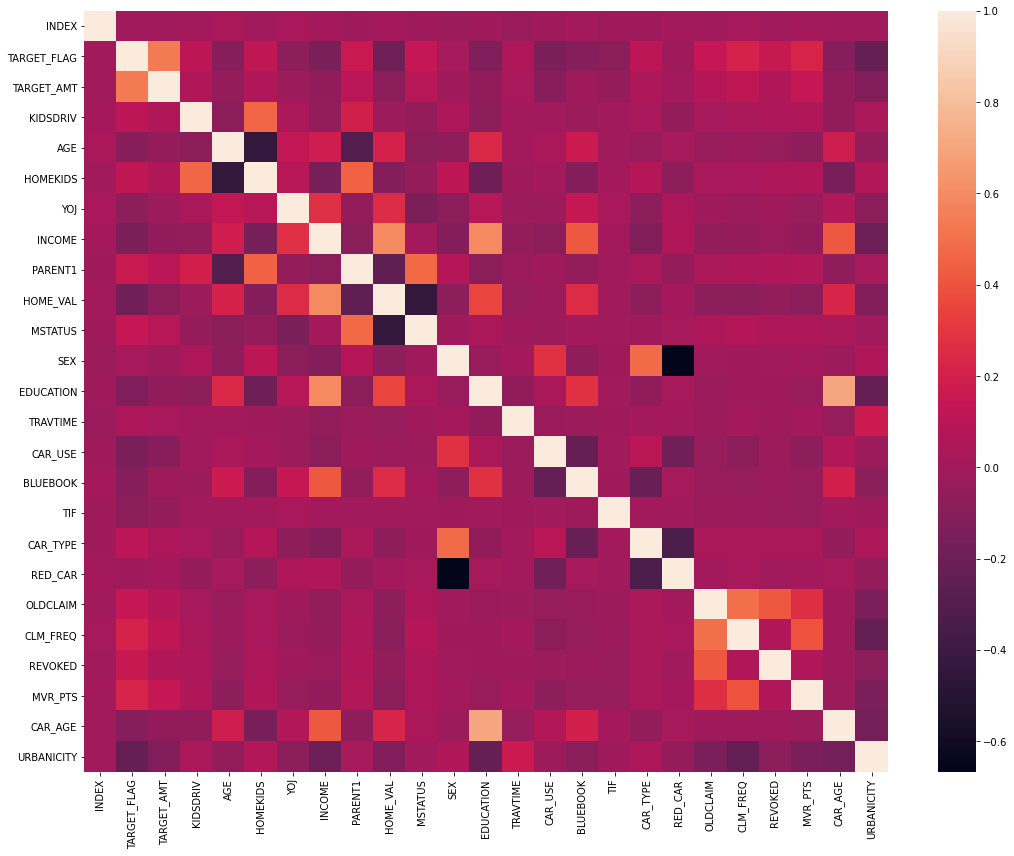

In [18]:
plt.figure(figsize=(18,14))
sns.heatmap(df.corr())

We can have a look at how the variables are distributed:

In [ ]:
for e in df.columns :
    #plt.hist(x=e,y='TARGET_FLAG')
    df[e].hist(bins=100,figsize=(15,5))
    plt.title(e)
    plt.show()

# 2. Model creation

The dataset has been cleaned, we are going to create our classification model. Our problem is a binary classification problem. However the dataset is a bit imbalanced and we make the assumption that the two classes don't have the same importance. Indeed the class 1 represents people who did claim money. From the insurer perspective it is important not to miss this behavior. A good classifier would be a one with a relatively low number of false negative. Then instead of using accuracy we will use precision and recall as metrics. 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#Split data into training/test set
X = df.drop(columns=['TARGET_FLAG','TARGET_AMT','INDEX']) 
columns = X.columns
X = X.values
y = df['TARGET_FLAG'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

## 2.1 Features elimination
We first use recursive feature elimination to delete features not improving performances

Optimal number of features :  20


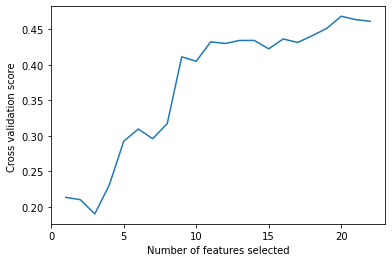

In [42]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
min_features_to_select = 1

rf = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(4),
              scoring='f1',   #combine recall and precision
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train, y_train)

print("Optimal number of features : " , rfecv.n_features_)


plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score ")
plt.plot(range(min_features_to_select,len(rfecv.grid_scores_) + min_features_to_select),rfecv.grid_scores_)
plt.show()


In [26]:
X = df.drop(columns=['TARGET_FLAG','TARGET_AMT','INDEX','PARENT1','SEX','RED_CAR']) #features to delete
columns = X.columns
X = X.values
y = df['TARGET_FLAG'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

## 2.2 Model Selection

We need to choose a classifier. We will focus only on tree based method such as Random Forest or XGBoost since they tend to have the best performance overall for this type of problem

Random Forest precision:  0.6706912794820109
XGBoost precision:  0.6736401002614198
Random Forest recall:  0.3513475961797874
XGBoost recall:  0.39547563805104413
XGBoost f1:  0.49775501535972994
Random Forest f1:  0.4603546081836148


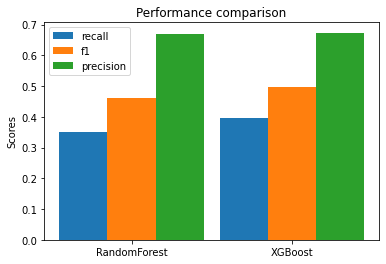

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
cv=StratifiedKFold(4)
rf = RandomForestClassifier()
cv_score = cross_validate(rf,X_train,y_train,scoring=['precision','recall','f1'],cv=cv)
rf_mean_recall = np.mean(cv_score['test_recall'])
rf_mean_precision = np.mean(cv_score['test_precision'])
rf_mean_f1 = np.mean(cv_score['test_f1'])

xgb = XGBClassifier()
cv_score = cross_validate(xgb,X_train,y_train,scoring=['precision','recall','f1'],cv=cv)
xgb_mean_recall = np.mean(cv_score['test_recall'])
xgb_mean_precision = np.mean(cv_score['test_precision'])
xgb_mean_f1 = np.mean(cv_score['test_f1'])

print("Random Forest precision: ",rf_mean_precision)
print("XGBoost precision: ",xgb_mean_precision)
print("Random Forest recall: ",rf_mean_recall)
print("XGBoost recall: ",xgb_mean_recall)
print("XGBoost f1: ",xgb_mean_f1)
print("Random Forest f1: ",rf_mean_f1)

labels = ['RandomForest', 'XGBoost']
recall = [rf_mean_recall, xgb_mean_recall]
precision = [rf_mean_precision, xgb_mean_precision]
f1 = [rf_mean_f1, xgb_mean_f1]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, recall, width, label='recall')
rects2 = ax.bar(x , f1, width, label='f1')
rects3 = ax.bar(x + width, precision, width, label='precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()


XGboost model seems to perform better on recall which is important here so we are going to focus on XGBoost

## 2.3 Features Engineering

In order to improve performance we will try to engineer new features that could trigger the claim

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,CLAIM_MEAN,CAR_USE_URBANICITY
0,1,0,0.0,0,60.0,0,11.0,67349.000000,0,0.000000,...,0,1,4461,2,0,3,18.0,0,640.096924,1
1,2,0,0.0,0,43.0,0,11.0,91449.000000,0,257252.000000,...,0,1,0,0,0,0,1.0,0,0.000000,0
2,4,0,0.0,0,35.0,1,10.0,16039.000000,0,124191.000000,...,5,0,38690,2,0,3,10.0,0,5551.524323,1
3,5,0,0.0,0,51.0,0,14.0,140271.059344,0,306251.000000,...,0,1,0,0,0,0,6.0,0,0.000000,1
4,6,0,0.0,0,50.0,0,12.0,114986.000000,0,243925.000000,...,5,0,19217,2,1,3,17.0,0,2757.395785,1
5,7,1,2946.0,0,34.0,1,12.0,125301.000000,1,0.000000,...,3,0,0,0,0,0,7.0,0,0.000000,0
6,8,0,0.0,0,54.0,0,12.0,18755.000000,0,93722.735035,...,5,0,0,0,0,0,1.0,0,0.000000,1
7,11,1,4021.0,1,37.0,2,12.0,107961.000000,0,333680.000000,...,4,1,2374,1,1,10,7.0,0,290.023036,0
8,12,1,2501.0,0,34.0,0,10.0,62978.000000,0,0.000000,...,5,0,0,0,0,0,1.0,0,0.000000,1
9,13,0,0.0,0,50.0,0,7.0,106952.000000,0,0.000000,...,4,0,0,0,0,1,17.0,1,0.000000,2


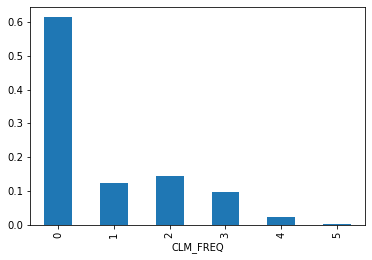

In [28]:

#First we to multiply claim frequancy with oldclaim to get a mean claim value
df_engineered = df.copy()
fq = df_engineered.groupby('CLM_FREQ').size()/len(df_engineered)    
df_engineered.loc[:,'CLAIM_MEAN'] = df_engineered['CLM_FREQ'].map(fq)*df_engineered['OLDCLAIM']


#We can also try to segment groups by combining different categorical value. For example we can combine car use with the area
df_engineered.loc[:,'CAR_USE_URBANICITY'] = df_engineered.apply(lambda x : str(x['URBANICITY']) + '_'+ str(x['CAR_USE']),axis=1)

le = LabelEncoder()
df_engineered.loc[:,'CAR_USE_URBANICITY'] = le.fit_transform(df_engineered['CAR_USE_URBANICITY'])


fq.plot.bar(stacked = True)   
df_engineered.head(10) 

In [29]:
#df_engineered = df.copy()['TARGET_FLAG','TARGET_AMT','INDEX','PARENT1','SEX','RED_CAR']
y = df_engineered['TARGET_FLAG'].values
df_engineered = df_engineered.drop(columns=['TARGET_FLAG','TARGET_AMT','SEX','INDEX','PARENT1','RED_CAR']) 
columns = df_engineered.columns
X = df_engineered.values
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

pd.Series(xgb.feature_importances_, index=columns).nlargest(20).plot(kind='barh')

Both features seem to have importance for the algorithm. Let's check if it can improve cross validated perfomance:

XGBoost precision:  0.6813919730521577
XGBoost recall:  0.40418712566772785
XGBoost f1:  0.5070955976805732


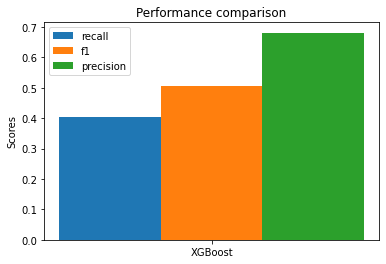

In [32]:
cv=StratifiedKFold(4)
xgb = XGBClassifier()

cv_score = cross_validate(xgb,X_train,y_train,scoring=['precision','recall','f1'],cv=cv)
xgb_mean_recall = np.mean(cv_score['test_recall'])
xgb_mean_precision = np.mean(cv_score['test_precision'])
xgb_mean_f1 = np.mean(cv_score['test_f1'])

print("XGBoost precision: ",xgb_mean_precision)
print("XGBoost recall: ",xgb_mean_recall)
print("XGBoost f1: ",xgb_mean_f1)

labels = ['XGBoost']
recall = [xgb_mean_recall]
precision = [ xgb_mean_precision]
f1 = [ xgb_mean_f1]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, recall, width, label='recall')
rects2 = ax.bar(x , f1, width, label='f1')
rects3 = ax.bar(x + width, precision, width, label='precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

The new features are useful but it is only slighlty improving performance. We might try to different combination of features to create more value for the classifier.

## 2.4 Hyperparameter optimization
In order to improve performance we can also tune the different parameters of XGBoost

In [33]:
from sklearn.model_selection import RandomizedSearchCV

#Search space
hparams = {"learning_rate"    : [0.05, 0.15, 0.25, 0.30,0.4,0.5 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15,17],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "scale_pos_weight" : [1,2,4,6],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

We perform Randomized search with a cross validation since it is less greedy than grid search. We are going to optimize f1 score

In [34]:
#Uncomment to run. It might take a few minutes. Skip to next cell for results

"""xgb = XGBClassifier()
cv=StratifiedKFold(4)

gcv = RandomizedSearchCV(xgb, hparams,scoring='f1',n_iter=300,n_jobs=-1,cv=cv)
gcv.fit(X_train,y_train)"""

"xgb = XGBClassifier()\ncv=StratifiedKFold(4)\n\ngcv = RandomizedSearchCV(xgb, hparams,scoring='f1',n_iter=300,n_jobs=-1,cv=cv)\ngcv.fit(X_train,y_train)"

Retrain with optimal parameters:

In [35]:
xgb_opt = XGBClassifier(min_child_weight=7,max_depth=12,learning_rate=0.05,gamma=0.4,colsample_bytree= 0.7,scale_pos_weight=4)
xgb_opt.fit(X_train,y_train)

XGBClassifier(colsample_bytree=0.7, gamma=0.4, learning_rate=0.05, max_depth=12,
              min_child_weight=7, scale_pos_weight=4)

Confusion matrix for optimized XGBoost


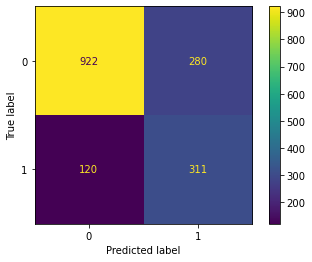

In [36]:
from sklearn.metrics import plot_confusion_matrix
print("Confusion matrix for optimized XGBoost")
plot_confusion_matrix(xgb_opt,X_test,y_test)
plt.show()

Confusion matrix for initial XGBoost


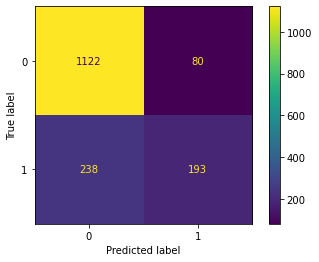

In [37]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
print("Confusion matrix for initial XGBoost")
plot_confusion_matrix(xgb,X_test,y_test)
plt.show()

As we can see with the confusion matrix, the optimized XGBoost miss less claims but tends to see false claims. There is a tradeoff between precision and recall. This is summarized with the following precision recall curve: 

xgb opt: f1=0.609 auc=0.660
xgb opt recall:  0.7215777262180975
xgb opt precision:  0.5262267343485617
xgb: f1=0.548 auc=0.637
xgb recall:  0.44779582366589327
xgb precision:  0.706959706959707


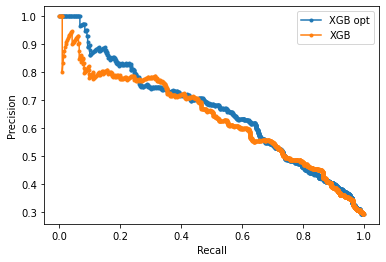

In [38]:
from sklearn.metrics import precision_recall_curve,f1_score,auc,recall_score,precision_score
xgb_probs_opt = xgb_opt.predict_proba(X_test)
xgb_probs = xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgb_probs_opt = xgb_probs_opt[:, 1]
xgb_probs = xgb_probs[:, 1]
# predict class values
yhat_opt = xgb_opt.predict(X_test)
yhat = xgb.predict(X_test)
xgb_precision_opt, xgb_recall_opt, _ = precision_recall_curve(y_test, xgb_probs_opt)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_f1_opt, xgb_auc_opt = f1_score(y_test, yhat_opt), auc(xgb_recall_opt, xgb_precision_opt)
xgb_f1, xgb_auc = f1_score(y_test, yhat), auc(xgb_recall, xgb_precision)
# summarize scores
print('xgb opt: f1=%.3f auc=%.3f' % (xgb_f1_opt, xgb_auc_opt))
print('xgb opt recall: ',recall_score(y_test, yhat_opt))
print('xgb opt precision: ',precision_score(y_test, yhat_opt))

print('xgb: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
print('xgb recall: ',recall_score(y_test, yhat))
print('xgb precision: ',precision_score(y_test, yhat))

plt.plot(xgb_recall_opt, xgb_precision_opt, marker='.', label='XGB opt')
plt.plot(xgb_recall, xgb_precision, marker='.', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

If you want to improve recall then precision will decline and vice versa. The ideal threshold would depend on the insurer. That threshold would be affected by the loss from each claim in TARGET_AMT value but is it out of the scope of study here. This classification problem is quiet hard since claims are affected by parameters that are not reflected in the data. For example bad weather could trigger a claim. Also some variable are a bit simplistic such as the urban area which is binary. It could be more precise and related to urban density.